# 2025 Tourism Pattern Mining (Nepal) — Association Rules with Apriori

This Colab notebook analyzes travel **destination co-visitation patterns** from a transactional tourism dataset (2025) using **Apriori** frequent itemset mining and **association rules**.

**Dataset (CSV)**: `np_tourism_2025_data.csv`  
**Columns**:
- `TravelerID`: unique traveler identifier (basket id)
- `Destination`: a destination visited by that traveler (item)

---

## Main idea

1. **Group** destinations by traveler → each traveler becomes a *basket* of visited destinations.
2. **One-hot encode** baskets (TransactionEncoder) → a binary matrix of destinations.
3. **Mine frequent itemsets** with Apriori (items that co-occur often).
4. **Generate association rules** (e.g., `Pokhara → Mustang`) and rank by **lift** and **confidence**.
5. **Summarize insights** for tourism planning/marketing.

---



## Algorithm used: Apriori + Association Rules

### Frequent itemset (Apriori)
For an itemset \($X$\):
- **Support**:  
  $
  \text{support}(X)=\frac{\#\{\text{transactions containing }X\}}{\#\{\text{transactions}\}}
  $
Apriori uses the **downward-closure property**: if an itemset is infrequent, *all of its supersets are infrequent*, so the search space can be pruned efficiently.

### Association rules
For a rule \(A \to B\):
- **Support**: \($\text{support}(A \cup B)$\)
- **Confidence**:  
  $
  \text{confidence}(A\to B)=\frac{\text{support}(A \cup B)}{\text{support}(A)}
  $
- **Lift**:  
  $
  \text{lift}(A\to B)=\frac{\text{confidence}(A\to B)}{\text{support}(B)}
  $
Interpretation:
- **Lift > 1**: positive association (co-occur more than expected if independent)
- **Lift ≈ 1**: near-independence
- **Lift < 1**: negative association

---



In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)


In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive/')

## set a folder as current working dir

os.chdir('/content/drive/My Drive/AI4T/AssociationRuleMining/')


Mounted at /content/drive/


In [ ]:
# Install required packages (Colab-safe)
!pip -q install mlxtend


In [ ]:
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 1) Load and clean the data


In [ ]:
from typing import List, Tuple, Dict

def load_tourism_data(csv_path: str) -> pd.DataFrame:
    """Load tourism transaction-style data from a CSV file.

    Input:
        csv_path: Path to CSV containing at least ['TravelerID', 'Destination'] columns.
    Output:
        df: Pandas DataFrame with raw tourism records.
    Task:
        Reads the CSV into a DataFrame.
    """
    return pd.read_csv(csv_path)


def clean_tourism_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Clean tourism records.

    Input:
        df_raw: DataFrame with columns ['TravelerID', 'Destination'].
    Output:
        df_clean: Cleaned DataFrame (trimmed strings, removed blanks, standardized destination text).
    Task:
        - Drop missing TravelerID/Destination
        - Strip whitespace
        - Remove trailing commas
        - Normalize repeated spaces
    """
    df = df_raw.copy()

    required = {'TravelerID', 'Destination'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

    df = df.dropna(subset=['TravelerID', 'Destination'])

    df['TravelerID'] = df['TravelerID'].astype(str).str.strip()
    df['Destination'] = (
        df['Destination'].astype(str)
          .str.strip()
          .str.replace(r',$', '', regex=True)
          .str.replace(r'\s+', ' ', regex=True)
    )

    df = df[df['Destination'].str.len() > 0].reset_index(drop=True)
    return df


# Load & clean (upload the CSV to Colab first)
csv_path = "data/np_tourism_2025_data.csv"
df_raw = load_tourism_data(csv_path)
df_un = clean_tourism_data(df_raw)

print("Rows, Cols:", df_un.shape)
display(df_un.head())


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Rows, Cols: (2633, 2)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,TravelerID,Destination
0,TR_0001,Lumbini
1,TR_0001,Pokhara
2,TR_0001,Chitwan
3,TR_0002,Baglung
4,TR_0002,Dharan


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 2) Build transaction baskets and one-hot encode


In [ ]:
def build_transactions(df: pd.DataFrame,
                       id_col: str = "TravelerID",
                       item_col: str = "Destination") -> List[List[str]]:
    """Group items into baskets (transactions) by traveler id.

    Input:
        df: Clean DataFrame with traveler id and destination columns.
        id_col: Basket identifier column name.
        item_col: Item column name.
    Output:
        transactions: List of lists; each inner list is destinations visited by one traveler.
    Task:
        Converts row-based visit logs into transaction baskets for Apriori.
    """
    return df.groupby(id_col)[item_col].apply(list).values.tolist()


def encode_transactions(transactions: List[List[str]]) -> pd.DataFrame:
    """One-hot encode transaction baskets for Apriori.

    Input:
        transactions: List of transaction baskets (list of destination lists).
    Output:
        df_basket: Binary DataFrame where columns are destinations and rows are travelers.
    Task:
        Uses TransactionEncoder to create a boolean matrix required by Apriori.
    """
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    return pd.DataFrame(te_ary, columns=te.columns_)


transactions = build_transactions(df_un)
df_basket = encode_transactions(transactions)

print("Transactions (travelers):", len(transactions))
print("Destinations (unique items):", df_basket.shape[1])
display(df_basket.head())


Transactions (travelers): 1000
Destinations (unique items): 11


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Baglung,Bhaktapur,Biratnagar,Chitwan,Dharan,Kathmandu,Lumbini,Mustang,Patan,Pokhara,Solukhumbu
0,False,False,False,True,False,False,True,False,False,True,False
1,True,False,False,False,True,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,True,False,False,False,False,False,True
4,True,False,True,False,False,False,False,False,False,True,False


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 3) Destination popularity + auto categories (High-growth vs Stable)

THe original script used `high_growth_2025` and `stable_markets`.

Here we auto-define:
- **High-growth (data-driven)**: top *N* destinations by traveler count  
- **Stable**: the remaining destinations


In [ ]:
def categorize_destinations(df_basket: pd.DataFrame, top_n: int = 5) -> Tuple[List[str], List[str], pd.Series]:
    """Categorize destinations into high-growth vs stable using popularity ranks.

    Input:
        df_basket: Binary basket matrix (rows=travelers, cols=destinations).
        top_n: Number of top destinations to label as 'high-growth' (heuristic).
    Output:
        high_growth: List of top_n destinations by traveler count.
        stable: List of remaining destinations.
        destination_counts: Series of counts sorted descending.
    Task:
        Provides a safe default categorization based on the dataset itself.
    """
    destination_counts = df_basket.sum().sort_values(ascending=False)
    high_growth = destination_counts.head(top_n).index.tolist()
    stable = [d for d in destination_counts.index.tolist() if d not in high_growth]
    return high_growth, stable, destination_counts


high_growth_2025, stable_markets, destination_counts = categorize_destinations(df_basket, top_n=5)

print("High-growth (auto):", high_growth_2025)
print("Stable (auto):", stable_markets)


High-growth (auto): ['Pokhara', 'Kathmandu', 'Chitwan', 'Mustang', 'Lumbini']
Stable (auto): ['Bhaktapur', 'Biratnagar', 'Patan', 'Baglung', 'Dharan', 'Solukhumbu']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


DESTINATION POPULARITY (2025 Forecast)
----------------------------------------
 HIGH-GROWTH: Pokhara      - 499 travelers ( 49.9%)
 HIGH-GROWTH: Kathmandu    - 279 travelers ( 27.9%)
 HIGH-GROWTH: Chitwan      - 236 travelers ( 23.6%)
 HIGH-GROWTH: Mustang      - 224 travelers ( 22.4%)
 HIGH-GROWTH: Lumbini      - 221 travelers ( 22.1%)
 STABLE MARKET: Bhaktapur    - 218 travelers ( 21.8%)
 STABLE MARKET: Biratnagar   - 204 travelers ( 20.4%)
 STABLE MARKET: Patan        - 198 travelers ( 19.8%)
 STABLE MARKET: Baglung      - 195 travelers ( 19.5%)
 STABLE MARKET: Dharan       - 188 travelers ( 18.8%)
 STABLE MARKET: Solukhumbu   - 171 travelers ( 17.1%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

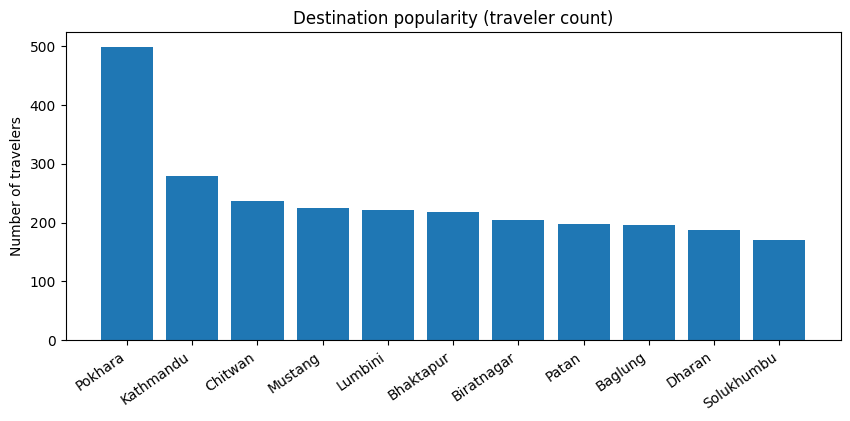

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
def print_destination_popularity(destination_counts: pd.Series,
                                 total_travelers: int,
                                 high_growth: List[str]) -> None:
    """Print destination popularity with a simple category label.

    Input:
        destination_counts: Series (destination -> traveler count), sorted.
        total_travelers: Number of transactions (travelers).
        high_growth: List of destinations labeled high-growth.
    Output:
        None (prints formatted lines).
    Task:
        Creates a readable popularity summary for reporting.
    """
    print("\nDESTINATION POPULARITY (2025 Forecast)")
    print("-" * 40)
    for dest, count in destination_counts.items():
        pct = (count / total_travelers) * 100
        category = " HIGH-GROWTH" if dest in high_growth else " STABLE MARKET"
        print(f"{category}: {dest:<12} - {int(count):>3} travelers ({pct:>5.1f}%)")


def plot_destination_popularity(destination_counts: pd.Series, top_k: int = 11) -> None:
    """Plot destination popularity as a bar chart.

    Input:
        destination_counts: Series (destination -> count), usually sorted.
        top_k: Number of top destinations to show.
    Output:
        None (displays a plot).
    Task:
        Visualizes how many travelers visited each destination.
    """
    top = destination_counts.head(top_k)
    plt.figure(figsize=(10,4))
    plt.bar(top.index.astype(str), top.values)
    plt.xticks(rotation=35, ha='right')
    plt.ylabel("Number of travelers")
    plt.title("Destination popularity (traveler count)")
    plt.show()


print_destination_popularity(destination_counts, len(df_basket), high_growth_2025)
plot_destination_popularity(destination_counts)


## 4) Mine frequent itemsets (Apriori) and generate rules


In [ ]:
def mine_frequent_itemsets(df_basket: pd.DataFrame,
                           min_support_primary: float = 0.03,
                           min_support_fallback: float = 0.02,
                           max_len: int = 3) -> pd.DataFrame:
    """Mine frequent itemsets using Apriori with a fallback support threshold.

    Input:
        df_basket: Binary basket matrix.
        min_support_primary: Main support threshold.
        min_support_fallback: Lower threshold used only if nothing is found.
        max_len: Maximum length of itemsets to mine.
    Output:
        frequent_itemsets: DataFrame of frequent itemsets with support.
    Task:
        Runs Apriori; if no itemsets are found, reruns with a lower threshold.
    """
    frequent_itemsets = apriori(df_basket, min_support=min_support_primary, use_colnames=True, max_len=max_len)

    if len(frequent_itemsets) == 0:
        print(f" No itemsets at min_support={min_support_primary}. Trying {min_support_fallback} ...")
        frequent_itemsets = apriori(df_basket, min_support=min_support_fallback, use_colnames=True, max_len=max_len)

    return frequent_itemsets


def generate_association_rules(frequent_itemsets: pd.DataFrame,
                               metric: str = "lift",
                               min_threshold: float = 0.8) -> pd.DataFrame:
    """Generate association rules from frequent itemsets.

    Input:
        frequent_itemsets: Output of Apriori (must include ['support','itemsets']).
        metric: Metric used for rule generation filter (e.g., 'lift', 'confidence').
        min_threshold: Minimum threshold for the chosen metric.
    Output:
        rules: DataFrame of association rules with support, confidence, lift, etc.
    Task:
        Converts itemsets into directional rules A -> B.
    """
    if len(frequent_itemsets) == 0:
        return pd.DataFrame()
    return association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)


frequent_itemsets = mine_frequent_itemsets(df_basket, 0.03, 0.02, max_len=3)
print("Frequent itemsets found:", len(frequent_itemsets))
display(frequent_itemsets.sort_values("support", ascending=False).head(10))

rules = generate_association_rules(frequent_itemsets, metric="lift", min_threshold=0.8)
print("Rules generated:", len(rules))
if len(rules) > 0:
    rules = rules.sort_values(['lift', 'confidence'], ascending=False)
display(rules.head(10))


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Frequent itemsets found: 46


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,support,itemsets
9,0.499,(Pokhara)
5,0.279,(Kathmandu)
3,0.236,(Chitwan)
7,0.224,(Mustang)
6,0.221,(Lumbini)
1,0.218,(Bhaktapur)
2,0.204,(Biratnagar)
8,0.198,(Patan)
0,0.195,(Baglung)
4,0.188,(Dharan)


Rules generated: 42


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
29,(Solukhumbu),(Dharan),0.171,0.188,0.040,0.233918,1.244245,1.0,0.007852,1.059939,0.236791,0.125392,0.056549,0.223342
28,(Dharan),(Solukhumbu),0.188,0.171,0.040,0.212766,1.244245,1.0,0.007852,1.053054,0.241749,0.125392,0.050381,0.223342
30,(Patan),(Kathmandu),0.198,0.279,0.066,0.333333,1.194743,1.0,0.010758,1.081500,0.203242,0.160584,0.075358,0.284946
31,(Kathmandu),(Patan),0.279,0.198,0.066,0.236559,1.194743,1.0,0.010758,1.050507,0.226075,0.160584,0.048079,0.284946
21,(Solukhumbu),(Chitwan),0.171,0.236,0.048,0.280702,1.189414,1.0,0.007644,1.062146,0.192099,0.133705,0.058510,0.242046
20,(Chitwan),(Solukhumbu),0.236,0.171,0.048,0.203390,1.189414,1.0,0.007644,1.040660,0.208442,0.133705,0.039071,0.242046
3,(Baglung),(Biratnagar),0.195,0.204,0.045,0.230769,1.131222,1.0,0.005220,1.034800,0.144099,0.127119,0.033630,0.225679
2,(Biratnagar),(Baglung),0.204,0.195,0.045,0.220588,1.131222,1.0,0.005220,1.032830,0.145729,0.127119,0.031787,0.225679
37,(Patan),(Mustang),0.198,0.224,0.049,0.247475,1.104798,1.0,0.004648,1.031195,0.118276,0.131367,0.030251,0.233112
36,(Mustang),(Patan),0.224,0.198,0.049,0.218750,1.104798,1.0,0.004648,1.026560,0.122239,0.131367,0.025873,0.233112


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 5) Filter “meaningful” rules and print top patterns


In [ ]:
def filter_meaningful_rules(rules: pd.DataFrame,
                            support_min: float = 0.025,
                            confidence_min: float = 0.30,
                            lift_min: float = 0.80) -> pd.DataFrame:
    """Filter association rules to keep only actionable/meaningful ones.

    Input:
        rules: Association rules DataFrame (from mlxtend).
        support_min: Minimum support for the combined itemset.
        confidence_min: Minimum confidence for A -> B.
        lift_min: Minimum lift (association strength vs independence).
    Output:
        meaningful_rules: Filtered and sorted rules.
    Task:
        Applies thresholds to reduce noise and keep stronger patterns.
    """
    if rules is None or len(rules) == 0:
        return pd.DataFrame()

    meaningful = rules[
        (rules['support'] >= support_min) &
        (rules['confidence'] >= confidence_min) &
        (rules['lift'] >= lift_min)
    ].copy()

    return meaningful.sort_values(['lift', 'confidence'], ascending=False)


def pretty_print_rules(meaningful_rules: pd.DataFrame,
                       high_growth: List[str],
                       top_k: int = 15) -> None:
    """Pretty-print top association rules with simple emojis.

    Input:
        meaningful_rules: Filtered rules DataFrame.
        high_growth: List of 'high-growth' destinations.
        top_k: Max number of rules to print.
    Output:
        None (prints formatted lines).
    Task:
        Creates a readable report table in the notebook output.
    """
    if len(meaningful_rules) == 0:
        print(" No meaningful association rules found.")
        return

    print("=" * 85)
    print("TOP 2025 TOURISM ASSOCIATION PATTERNS")
    print("=" * 85)
    print(f"{'FROM':<25} {'→ TO':<25} {'SUPPORT':<10} {'CONFIDENCE':<12} {'LIFT':<8}")
    print("-" * 85)

    for _, row in meaningful_rules.head(top_k).iterrows():
        antecedents = ', '.join(sorted(list(row['antecedents'])))
        consequents = ', '.join(sorted(list(row['consequents'])))

        ante_type = "HOT" if any(d in high_growth for d in row['antecedents']) else "STABLE"
        cons_type = "HOT" if any(d in high_growth for d in row['consequents']) else "STABLE"

        print(f"{ante_type} {antecedents:<23} → {cons_type} {consequents:<23} "
              f"{row['support']:.3f}     {row['confidence']:.3f}      {row['lift']:.3f}")

    print("=" * 85)


meaningful_rules = filter_meaningful_rules(rules, 0.025, 0.30, 0.80)
print("✅ Meaningful rules:", len(meaningful_rules))
pretty_print_rules(meaningful_rules, high_growth_2025, top_k=15)
display(meaningful_rules.head(15))


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✅ Meaningful rules: 5
TOP 2025 TOURISM ASSOCIATION PATTERNS
FROM                      → TO                      SUPPORT    CONFIDENCE   LIFT    
-------------------------------------------------------------------------------------
STABLE Patan                   → HOT Kathmandu               0.066     0.333      1.195
HOT Mustang                 → HOT Pokhara                 0.113     0.504      1.011
HOT Chitwan                 → HOT Pokhara                 0.111     0.470      0.943
HOT Lumbini                 → HOT Pokhara                 0.094     0.425      0.852
HOT Kathmandu               → HOT Pokhara                 0.117     0.419      0.840


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
30,(Patan),(Kathmandu),0.198,0.279,0.066,0.333333,1.194743,1.0,0.010758,1.081500,0.203242,0.160584,0.075358,0.284946
39,(Mustang),(Pokhara),0.224,0.499,0.113,0.504464,1.010950,1.0,0.001224,1.011027,0.013959,0.185246,0.010907,0.365459
19,(Chitwan),(Pokhara),0.236,0.499,0.111,0.470339,0.942563,1.0,-0.006764,0.945888,-0.073869,0.177885,-0.057208,0.346392
35,(Lumbini),(Pokhara),0.221,0.499,0.094,0.425339,0.852384,1.0,-0.016279,0.871819,-0.181878,0.150160,-0.147027,0.306858
33,(Kathmandu),(Pokhara),0.279,0.499,0.117,0.419355,0.840390,1.0,-0.022221,0.862833,-0.208495,0.177005,-0.158972,0.326912


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

**About one-third of travelers who visit Patan also visit Kathmandu, and this happens about 19% more often than expected by chance, making it a meaningful but moderate tourism association.**

- “If a traveler visits **Patan**, then they are likely to visit **Kathmandu**.”
- 19.8% of all travelers visited Patan, regardless of whether they visited Kathmandu.
- 27.9% of all travelers visited Kathmandu.
- support(Patan∪Kathmandu) = 0.066 i.e. 6.6% of travelers visited both Patan and Kathmandu
- confidence(Patan→Kathmandu) = 33.3% , i.e. 0.333 of Patan visitors also visited Kathmandu
- Lift > 1 ⇒ positive association, i.e. Visiting Patan increases the likelihood of visiting Kathmandu by ~19% above chance
- Representativity = 1.0, i.e. Indicates the rule is fully representative of the dataset (**NOT BIASED**)



- Leverage = 0.010758, ( Actual co-occurrence is 1.07% higher than expected by chance, i.e.  absolute improvement)
- conviction>1 (  Higher conviction ⇒ stronger implication i.e. Rule makes fewer wrong predictions than random)
- Zhang’s Metric =  0.203242 ( Positive value ⇒ positive association i.e. Confirms Patan → Kathmandu is meaningful)
- Jaccard= 0.160584 (Measures overlap similarity i.e. 16.1% overlap between Patan and Kathmandu visitors)
- Certainty = 0.075358 (Measures confidence stability is Low but positive ⇒ rule is valid but not extremely strong i.e.  supportable but cautious use)




### Quick visual: confidence vs lift

Useful to spot strong rules:
- Upper-right area → high confidence and high lift (often most actionable).


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

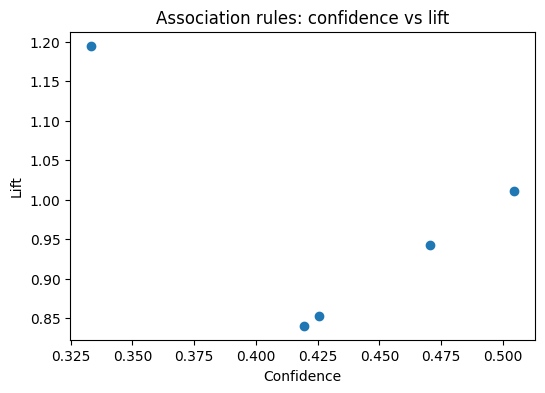

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
def plot_rules_scatter(rules_df: pd.DataFrame, max_points: int = 200) -> None:
    """Scatter plot of confidence vs lift for rules.

    Input:
        rules_df: Association rules DataFrame.
        max_points: Limit points for readability.
    Output:
        None (shows plot).
    Task:
        Visualizes rule strength (lift) vs reliability (confidence).
    """
    if len(rules_df) == 0:
        print("No rules to plot.")
        return

    plot_df = rules_df.head(max_points)
    plt.figure(figsize=(6,4))
    plt.scatter(plot_df['confidence'], plot_df['lift'])
    plt.xlabel("Confidence")
    plt.ylabel("Lift")
    plt.title("Association rules: confidence vs lift")
    plt.show()


plot_rules_scatter(meaningful_rules)


## 6) Generate simple “business insights” from rules


In [ ]:
def generate_tourism_insights(meaningful_rules: pd.DataFrame,
                             high_growth: List[str],
                             stable: List[str]) -> Dict[str, List[str]]:
    """Generate short, business-friendly insights from filtered rules.

    Input:
        meaningful_rules: Filtered rules DataFrame.
        high_growth: High-growth destination list.
        stable: Stable destination list.
    Output:
        insights: Dict of insight categories to bullet strings.
    Task:
        Converts rules into tourism marketing/planning insights.
    """
    insights = {
        "Emerging Market Corridors": [],
        "Gateway Patterns (Growth → Stable)": [],
        "Market Expansion (Stable → Growth)": [],
        "Regional Focus Pairs": []
    }

    if len(meaningful_rules) == 0:
        return insights

    growth_to_growth = meaningful_rules[
        meaningful_rules['antecedents'].apply(lambda x: any(d in high_growth for d in x)) &
        meaningful_rules['consequents'].apply(lambda x: any(d in high_growth for d in x))
    ]
    if len(growth_to_growth) > 0:
        row = growth_to_growth.iloc[0]
        insights["Emerging Market Corridors"].append(
            f"Travelers who visit {list(row['antecedents'])} are {row['confidence']:.0%} likely to also visit {list(row['consequents'])} (Lift={row['lift']:.2f})."
        )

    growth_to_stable = meaningful_rules[
        meaningful_rules['antecedents'].apply(lambda x: any(d in high_growth for d in x)) &
        meaningful_rules['consequents'].apply(lambda x: any(d in stable for d in x))
    ]
    for _, row in growth_to_stable.head(3).iterrows():
        insights["Gateway Patterns (Growth → Stable)"].append(
            f"{list(row['antecedents'])} → {list(row['consequents'])} (Confidence={row['confidence']:.0%}, Lift={row['lift']:.2f})"
        )

    stable_to_growth = meaningful_rules[
        meaningful_rules['antecedents'].apply(lambda x: any(d in stable for d in x)) &
        meaningful_rules['consequents'].apply(lambda x: any(d in high_growth for d in x))
    ]
    for _, row in stable_to_growth.head(3).iterrows():
        insights["Market Expansion (Stable → Growth)"].append(
            f"{list(row['antecedents'])} → {list(row['consequents'])} (Confidence={row['confidence']:.0%}, Lift={row['lift']:.2f})"
        )

    regional_rules = meaningful_rules[
        meaningful_rules.apply(lambda x: len(x['antecedents']) == 1 and len(x['consequents']) == 1, axis=1)
    ]
    for _, row in regional_rules.head(5).iterrows():
        a = list(row['antecedents'])[0]
        b = list(row['consequents'])[0]
        insights["Regional Focus Pairs"].append(
            f"{a} → {b}: Confidence={row['confidence']:.0%}, Lift={row['lift']:.2f}"
        )

    return insights


insights = generate_tourism_insights(meaningful_rules, high_growth_2025, stable_markets)

print("💡 2025 TOURISM INSIGHTS")
print("-" * 40)
for k, bullets in insights.items():
    if bullets:
        print(f"\n{k}:")
        for b in bullets:
            print(" •", b)


💡 2025 TOURISM INSIGHTS
----------------------------------------

Emerging Market Corridors:
 • Travelers who visit ['Mustang'] are 50% likely to also visit ['Pokhara'] (Lift=1.01).

Market Expansion (Stable → Growth):
 • ['Patan'] → ['Kathmandu'] (Confidence=33%, Lift=1.19)

Regional Focus Pairs:
 • Patan → Kathmandu: Confidence=33%, Lift=1.19
 • Mustang → Pokhara: Confidence=50%, Lift=1.01
 • Chitwan → Pokhara: Confidence=47%, Lift=0.94
 • Lumbini → Pokhara: Confidence=43%, Lift=0.85
 • Kathmandu → Pokhara: Confidence=42%, Lift=0.84


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 7) Regional pair frequency (optional reporting)

Given a list of destination pairs, compute:
- number of travelers who visited both
- support of the pair


In [ ]:
def default_regional_pairs(destinations: List[str]) -> List[Tuple[str, str]]:
    """Create a reasonable default set of destination pairs (editable).

    Input:
        destinations: List of destination names (columns in df_basket).
    Output:
        pairs: List of (dest1, dest2).
    Task:
        Provides example pairs; only keeps those that exist in the dataset.
    """
    candidate_pairs = [
        ("Pokhara", "Mustang"),
        ("Kathmandu", "Patan"),
        ("Kathmandu", "Bhaktapur"),
        ("Pokhara", "Chitwan"),
        ("Lumbini", "Chitwan"),
    ]
    return [(a, b) for (a, b) in candidate_pairs if a in destinations and b in destinations]


def compute_pair_frequency(df_basket: pd.DataFrame,
                           pairs: List[Tuple[str, str]]) -> pd.DataFrame:
    """Compute pair co-visit frequency and support.

    Input:
        df_basket: Binary basket matrix.
        pairs: List of destination pairs (column names).
    Output:
        df_pairs: DataFrame with pair, count_both, support.
    Task:
        Counts how often each pair co-occurs across travelers.
    """
    n = len(df_basket)
    rows = []
    for a, b in pairs:
        both_count = ((df_basket[a] == 1) & (df_basket[b] == 1)).sum()
        rows.append({
            "Destination A": a,
            "Destination B": b,
            "Both count": int(both_count),
            "Support": both_count / n
        })
    return pd.DataFrame(rows).sort_values("Support", ascending=False).reset_index(drop=True)


regional_pairs = default_regional_pairs(df_basket.columns.tolist())
df_pairs = compute_pair_frequency(df_basket, regional_pairs)

print("REGIONAL PAIR FREQUENCY")
display(df_pairs)


REGIONAL PAIR FREQUENCY


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,Destination A,Destination B,Both count,Support
0,Pokhara,Mustang,113,0.113
1,Pokhara,Chitwan,111,0.111
2,Kathmandu,Patan,66,0.066
3,Kathmandu,Bhaktapur,52,0.052
4,Lumbini,Chitwan,46,0.046


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 8) Save outputs (CSV)

- `np_2025_tourism_rules.csv`: filtered “meaningful” rules


In [ ]:
def save_rules(rules_df: pd.DataFrame, out_csv: str = "np_2025_tourism_rules.csv") -> str:
    """Save rules to CSV.

    Input:
        rules_df: Rules DataFrame to save.
        out_csv: Output CSV filename.
    Output:
        out_csv: The same path (for convenience).
    Task:
        Writes results to disk for reporting.
    """
    rules_df.to_csv(out_csv, index=False)
    return out_csv


if len(meaningful_rules) > 0:
    out_path = save_rules(meaningful_rules, "np_2025_tourism_rules.csv")
    print("Saved:", out_path)
else:
    print("No meaningful rules to save.")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Saved: np_2025_tourism_rules.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 9) Strategic recommendations (template)

These are general recommendations aligned with the patterns mined above.


In [ ]:
def print_recommendations() -> None:
    """Print short strategic recommendations based on association rule mining.

    Input:
        None
    Output:
        None (prints recommendations).
    Task:
        Gives a concise, business-facing summary suitable for a report slide.
    """
    print(" STRATEGIC RECOMMENDATIONS FOR 2025:")
    print("1. Bundle multi-destination packages based on high-confidence rules (A → B).")
    print("2. Design regional circuits using high-lift pairs (strongest co-visit relationships).")
    print("3. Use rules for cross-selling: recommend B to travelers searching for A.")
    print("4. Prioritize transport/experience links in corridors showing frequent co-visitation.")


print_recommendations()


 STRATEGIC RECOMMENDATIONS FOR 2025:
1. Bundle multi-destination packages based on high-confidence rules (A → B).
2. Design regional circuits using high-lift pairs (strongest co-visit relationships).
3. Use rules for cross-selling: recommend B to travelers searching for A.
4. Prioritize transport/experience links in corridors showing frequent co-visitation.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag